<a href="https://colab.research.google.com/github/G-Karishni/German-Traffic-Sign-Recognition-Benchmark/blob/main/German_Sign_Recgonition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pattern Recognition**
###Dataset : German Traffic Sign Recognition Benchmark
###Algorithm : MobileNet v1 CNN


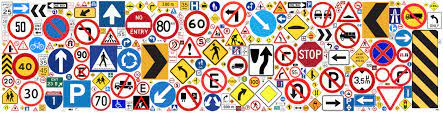





# *Prerequisites*

Add TensorFlow Hub dependency

In [1]:
!pip install tensorflow_hub

Importing libraries

In [2]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score

#*Output configurations*

Directories where we'll store notebook output - TensorFlow Lite model and labels for classification.

In [3]:
OUTPUT_ROOT_DIR = "output/"
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.tflite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")

#*Model configuration*

In [4]:
SELECTED_MOBILENET = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

IMAGE_SHAPE = (224, 224)

MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

#Input layer of MobileNet v1 has constant name called "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
#Output layer can be defined by us, default one is "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

#*Fetching dataset*

In [5]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [6]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation    
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:-- 

In [7]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 10.4 s, sys: 4.49 s, total: 14.9 s
Wall time: 16.4 s


Assigning labels to all the 43 class. Originally dataset operates on numerical labels (e.g. "00000").

In [8]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()

The GTSRB dataset is that images are stored as *.ppm files, which aren't supported by TensorFlow by default. To make it possible we need to convert them to .jpg files.

In [9]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [10]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 15 s, sys: 3.82 s, total: 18.9 s
Wall time: 19 s


Print all categories with example image for each of them.

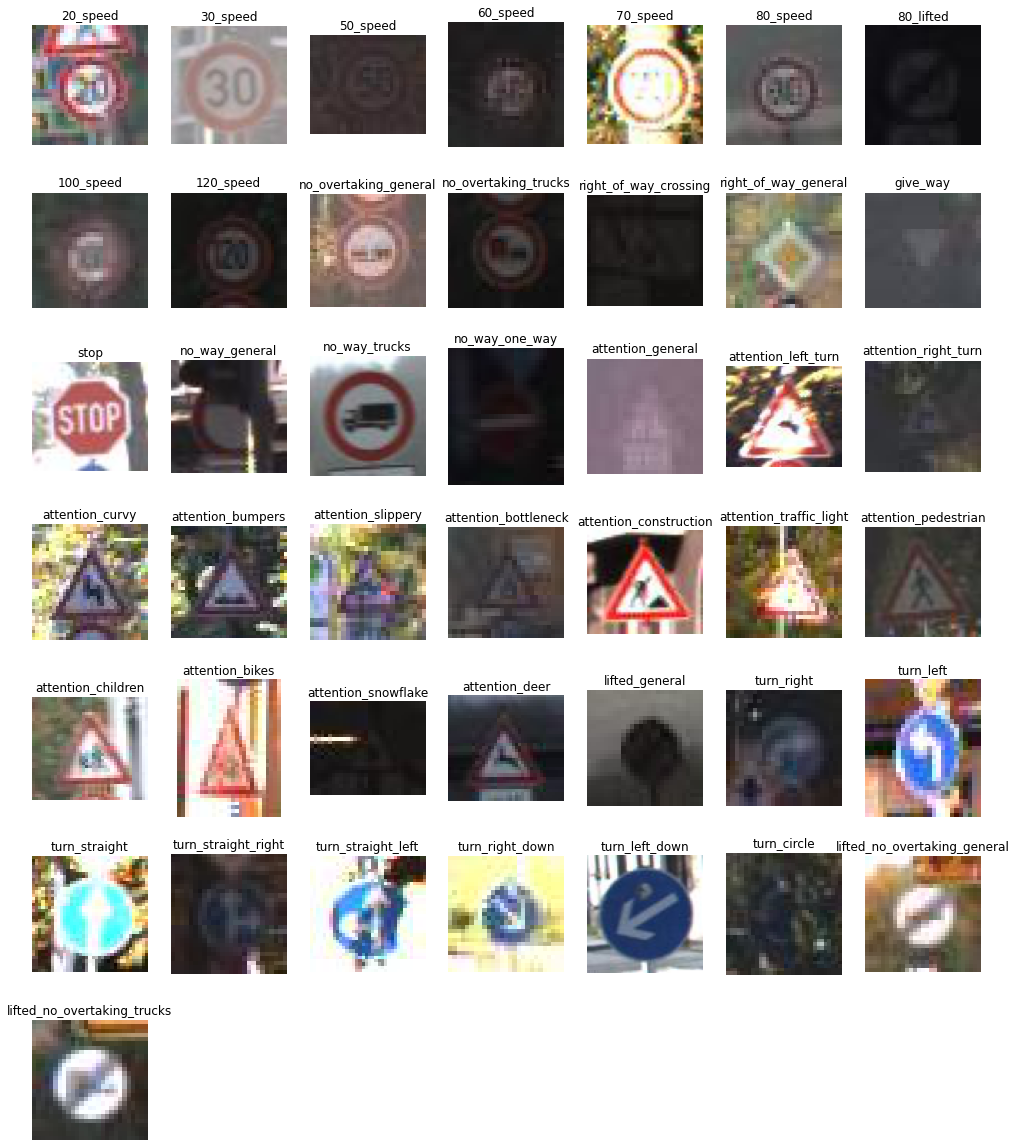

In [11]:
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. Use the ImageDataGenerator's rescale parameter to achieve this.

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=IMAGE_SHAPE)

Found 39209 images belonging to 43 classes.


The resulting object is an iterator that returns image_batch, label_batch pairs.

In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


# *Validation dataset preparation*

Convert also the validation dataset from *.ppm to *.jpg

In [14]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [15]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()
    
print("Validation images count:", len(validation_images))

Validation images count: 12630
CPU times: user 5.95 s, sys: 1.45 s, total: 7.4 s
Wall time: 7.49 s


# *Training*

Download a headless model using feature_extractor_url:
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


In [16]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [17]:
feature_extractor_layer.trainable = False

Attach a classification head

In [18]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 43)                55083     
                                                                 
Total params: 2,313,067
Trainable params: 55,083
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
predictions = model(image_batch)

In [20]:
predictions.shape

TensorShape([32, 43])

Use compile to configure the training process

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [22]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

Start training the network: Time taken (35 mins)

In [23]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
 
batch_stats_callback = CollectBatchStats()
 
history = model.fit(image_data, epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/5
1226/1226 [==============================] - 1084s 881ms/step - loss: 1.3791 - acc: 0.5625
Epoch 2/5
1226/1226 [==============================] - 1083s 883ms/step - loss: 0.5141 - acc: 0.8438
Epoch 3/5
1226/1226 [==============================] - 1086s 886ms/step - loss: 0.6707 - acc: 0.7812
Epoch 4/5
1226/1226 [==============================] - 1067s 870ms/step - loss: 0.5091 - acc: 0.7812
Epoch 5/5
1226/1226 [==============================] - 1068s 871ms/step - loss: 0.6629 - acc: 0.7812


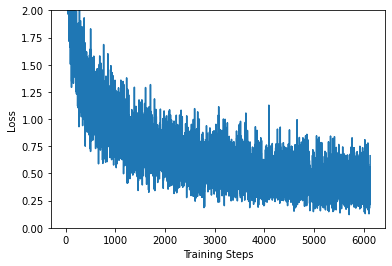

In [24]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

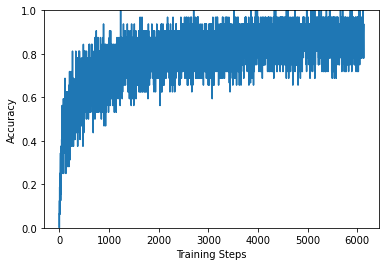

In [25]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

#*Model evaluation*

Load the validation data from the CSV file into a pandas data frame. Also change the file ending from *.ppm to *.jpg in the Filename column. Then also rescale the values for the model. The ClassId must be a string and with leading zeros, because this classification naming was also used for the subfolders in the training dataset.

In [26]:
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(val_data_frame, x_col="Filename", directory=VALIDATION_DATA_DIR, y_col="ClassId", target_size=IMAGE_SHAPE)

Found 12630 validated image filenames belonging to 43 classes.


In [27]:
for image_val_batch, label_val_batch in image_val_data:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


Running one image batch through the model and extract the predicted traffic sign ID.

In [28]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

Displaying the images in one batch with the prediction result. Printing the accuracy for the displayed batch.

Accuracy of the shown eval batch:


0.71875

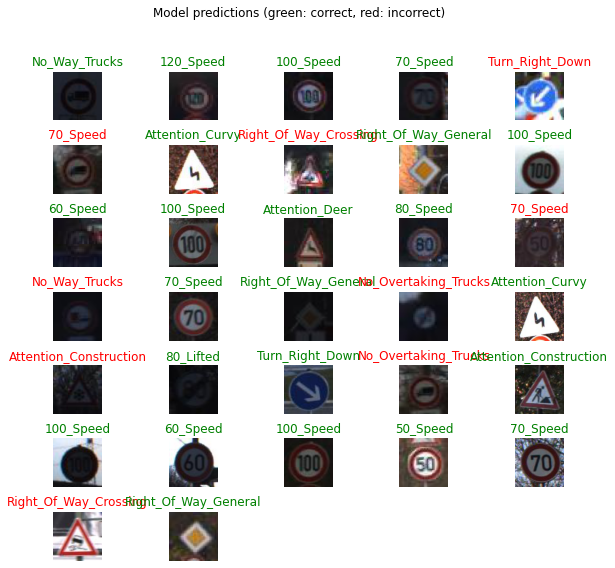

In [29]:
batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row,num_plot_column,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

print("Accuracy of the shown eval batch:")
accuracy_score(label_id, predicted_id)

Calculating the prediction accuracy and loss for all images in the validation dataset

In [30]:
score = model.evaluate(x=image_val_data, batch_size=image_val_data.batch_size, steps=image_val_data.samples/image_val_data.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])


394/394 [==============================] - 345s 872ms/step - loss: 1.1031 - acc: 0.6825
Loss:  1.1030787229537964 Accuracy:  0.6825019717216492


Calculating other performance metrix

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print ("Accuracy : ", accuracy_score(label_id, predicted_id))
print ("Confusion matrix : ", confusion_matrix(label_id, predicted_id))
print('Precision: %.3f' %precision_score(label_id, predicted_id, average='weighted'))
print('Recall: %.3f' %recall_score(label_id, predicted_id, average='weighted'))

Accuracy :  0.71875
Confusion matrix :  [[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
Precision: 0.728
Recall: 0.719


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
